In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import date

In [51]:
clim = pd.read_csv('T10Y2Y.csv', index_col=0, parse_dates=True)
clim.index=pd.to_datetime(clim.index)
clim[clim=="."]=np.nan
clim["T10Y2Y"]=clim["T10Y2Y"].astype(np.float64)

In [52]:
clim

,T10Y2Y
DATE,
2018-11-16,0.27
2018-11-19,0.27
2018-11-20,0.27
2018-11-21,0.25
2018-11-22,NaN
...,...
2023-11-10,-0.43
2023-11-13,-0.39
2023-11-14,-0.36


/tmp/ipykernel_72989/4103469751.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clim['T10Y2Y'])


<AxesSubplot: xlabel='T10Y2Y', ylabel='Density'>

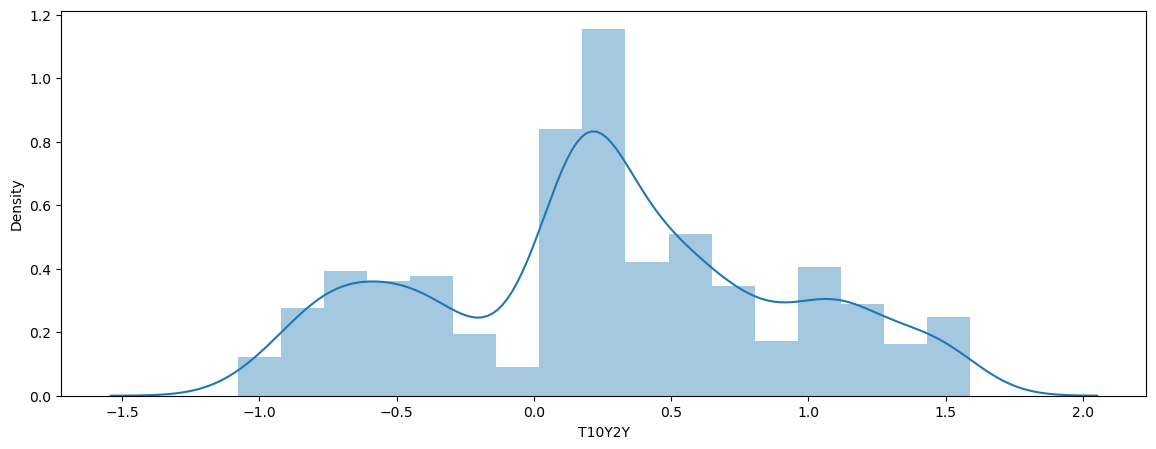

In [53]:
plt.figure(figsize = (14,5))
sns.distplot(clim['T10Y2Y'])

In [59]:
def Sequential_Input_LSTM(df, input_sequence):
    df_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_np) - input_sequence):
        row = [a for a in df_np[i:i + input_sequence]]
        X.append(row)
        label = df_np[i + input_sequence]
        y.append(label)
        
    return np.array(X), np.array(y)


n_input = 10      

df_min_model_data = clim['T10Y2Y'].dropna()

X, y = Sequential_Input_LSTM(df_min_model_data, n_input)

In [60]:
# Training data
X_train, y_train = X[:60000], y[:60000]

# Validation data
X_val, y_val = X[60000:65000], y[60000:65000]

# Test data
X_test, y_test = X[65000:], y[65000:]

In [61]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam 

In [62]:
n_features = 1                        

model1 = Sequential()

model1.add(InputLayer((n_input,n_features)))
model1.add(LSTM(100, return_sequences = True))     
model1.add(LSTM(100, return_sequences = True))
model1.add(LSTM(50))
model1.add(Dense(8, activation = 'relu'))
model1.add(Dense(1, activation = 'linear'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 100)           40800     
                                                                 
 lstm_7 (LSTM)               (None, 10, 100)           80400     
                                                                 
 lstm_8 (LSTM)               (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 8)                 408       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 151817 (593.04 KB)
Trainable params: 151817 (593.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

model1.compile(loss = MeanSquaredError(), 
               optimizer = Adam(learning_rate = 0.0001), 
               metrics = RootMeanSquaredError())

model1.fit(X_train, y_train, 
           validation_data = (X_val, y_val), 
           epochs = 50, 
           callbacks = [early_stop])

Epoch 1/50
35/39 [=========================>....] - ETA: 0s - loss: 0.4203 - root_mean_squared_error: 0.6483

ValueError: Expected input data to be non-empty.

<AxesSubplot: >

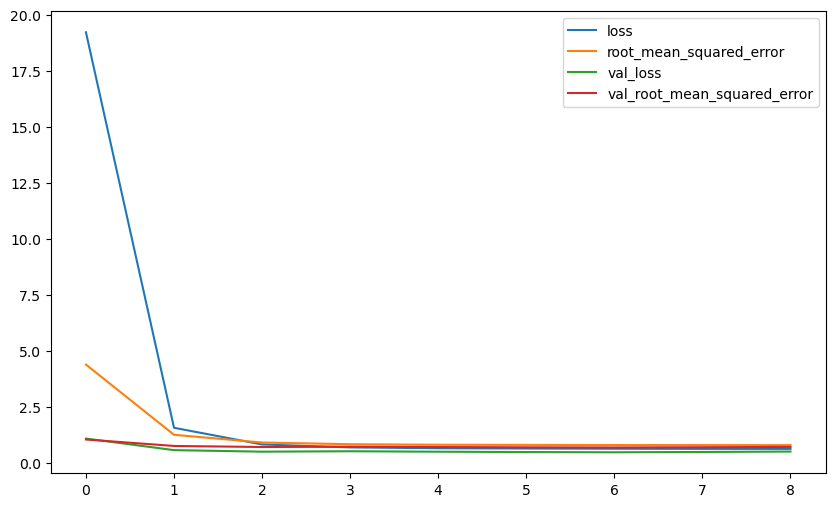

In [13]:
losses_df1 = pd.DataFrame(model1.history.history)

losses_df1.plot(figsize = (10,6))

In [14]:
test_predictions1 = model1.predict(X_test).flatten()


X_test_list = []
for i in range(len(X_test)):
    X_test_list.append(X_test[i][0])
    

test_predictions_df1 = pd.DataFrame({'X_test':list(X_test_list), 
                                    'LSTM Prediction':list(test_predictions1)})

159/159 [==============================] - 2s 4ms/step


<AxesSubplot: >

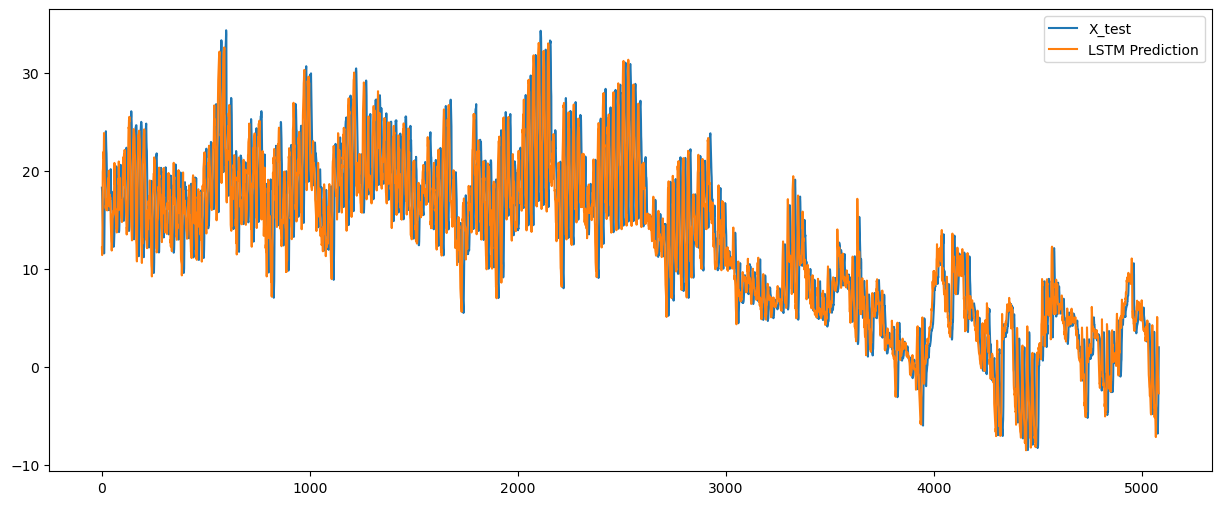

In [15]:
test_predictions_df1.plot(figsize = (15,6))


<AxesSubplot: >

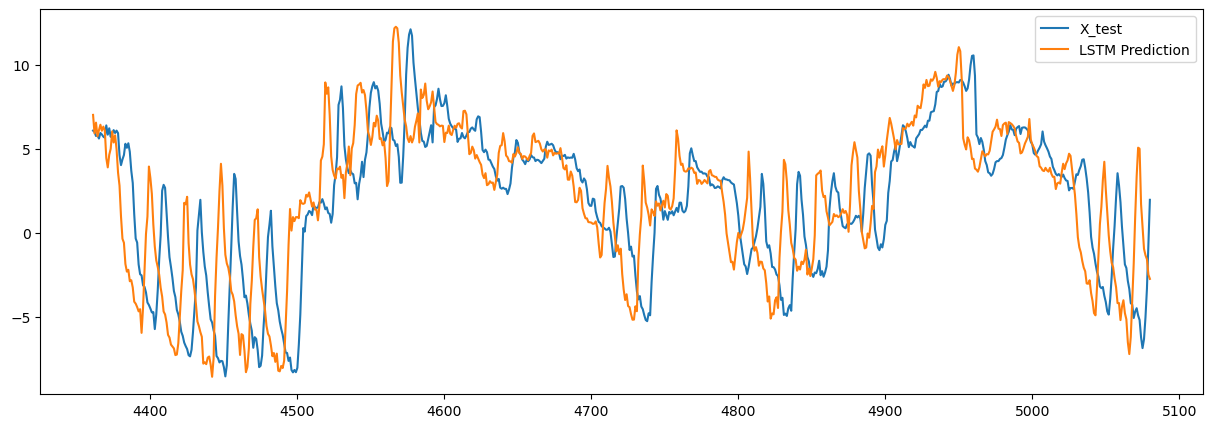

In [26]:
test_predictions_df1[(len(X_test) - 720):].plot(figsize = (15,5))

In [20]:
#Now let’s make future forecasts using LSTM model
def futureForecast(df, col, n_input, n_features, forecast_timeperiod, model):

    x_input = np.array(df[len(df)-n_input:][col])

    temp_input=list(x_input)

    lst_output=[]
    i=0

    while(i < forecast_timeperiod):

        if(len(temp_input) > n_input):

            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape((1, n_input, n_features))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])
            temp_input = temp_input[1:]
            lst_output.append(yhat[0][0])

            i=i+1

        else:
            x_input = x_input.reshape((1, n_input, n_features))
            yhat = model.predict(x_input, verbose=0)
            #print(yhat[0])
            temp_input.append(yhat[0][0])
            lst_output.append(yhat[0][0])

            i=i+1
            
    return lst_output
